In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from keras.metrics import MeanSquaredError
import tensorflow as tf
import keras
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD

#랜덤 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#MDD 계산함수 수정버전 (최저점 먼저 구해서 mdd 바로 계산)
def cal_mdd2(df):
    # MDD 계산
    # 1. 종가에서 1년기간 단위 최고치 peak를 구함
    peak = df['MKTCAP'].rolling(window=len(df), min_periods=1).max()

    # 2. 1년간 동안의 최저치를 구함
    min_price = df['MKTCAP'].rolling(window=len(df), min_periods=1).min()

    # 3. MDD 계산
    mdd = (min_price / peak - 1).min()

    print("mdd: ", mdd)

    return mdd

# 공통 함수

In [ ]:
#쉼표제거
def remove_commas(value):
  if isinstance(value, str):
    return int(value.replace(',' , ''))
  return value

# 오리지널 주식 데이터 불러오는 함수
def load_origin_data_30(file_name):
    file_path = "/content/drive/MyDrive/0_Capstone/data/merged_completed/" + file_name


    # 주식 데이터 불러오기
    all_data_orign = pd.read_csv(file_path)
    #ta-lib패키지에 맞게 컬럼명 변경하기
    all_data_orign.rename(columns={
        'TRD_DD': 'Timestamp',
        'TDD_CLSPRC': 'Close',
        'TDD_OPNPRC': 'Open',
        'TDD_HGPRC': 'High',
        'TDD_LWPRC': 'Low',
        'ACC_TRDVOL': 'Volume'
    }, inplace=True)

    #Timestamp 컬럼 datatime 타입 변경
    all_data_orign['Timestamp'] = pd.to_datetime(all_data_orign['Timestamp'])
    all_data_orign = all_data_orign.applymap(remove_commas)
    #df 날짜 역순변경
    all_data_orign["TRD_DD1"] = pd.to_datetime(all_data_orign["Timestamp"])
    all_data_orign.sort_values(by =['TRD_DD1'],ascending = True, inplace= True)
    all_data_orign.set_index('TRD_DD1', inplace=True)

    columns_to_drop = ['Open', 'High', 'Low', 'Volume']
    all_data_orign.drop(columns=columns_to_drop, inplace=True)

    #예측 정확도 계산에 이용될 30% 데이터 추출
    all_data_orign.sort_values(by='Timestamp', inplace=True)
    total_data_len = len(all_data_orign)
    cut = int(total_data_len*0.7)
    all_data_orign_30  = all_data_orign.iloc[cut:]

    return all_data_orign_30

#트렌드 포함 데이터 불러오는 함수
def load_trend_data(file_name):
  file_name = file_name.split('.')[0]
  file_path = "/content/drive/MyDrive/0_Capstone/data/merged_trend/" + file_name + "_preprocessed.csv"
  all_data= pd.read_csv(file_path)
  all_data.set_index('TRD_DD', inplace=True)
  return all_data

#train/test 데이터 준비 함수
def ts_train_test(all_data, time_steps, for_periods):
  # Extract the features (independent variables)
    features = all_data[['RSI_sig', 'SMA_sig', 'BBND_sig', 'ROC_sig', 'DPO_sig', 'STOCH_sig', 'MACD_sig', 'GDC_sig']].values

    # Extract the target variable (dependent variable)
    target = all_data['TREND'].values

    # Split the data into training and test sets
    total_data_len = len(all_data)
    cut = int(total_data_len*0.7)
    ts_X_train = features[:cut]
    ts_y_train = target[:cut]
    ts_X_test = features[cut - time_steps:]

    # Reshape data for RNN
    X_train = []
    y_train = []
    X_test = []

    for i in range(time_steps, len(ts_X_train) - for_periods + 1):
        X_train.append(features[i - time_steps:i])
        y_train.append(target[i:i + for_periods])

    for i in range(time_steps, len(ts_X_test)):
        X_test.append(features[i - time_steps:i])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)

    # Convert data types to float64
    X_train = X_train.astype(np.float64)
    y_train = y_train.astype(np.float64)

    return X_train, y_train, X_test

#모델 예측값을 시그널로 변경하는 함수
def pred_to_sig(all_data_orign_30, model_pred, model_pred_sig, threshold_low, threshold_high):
  all_data_orign_30[model_pred_sig] = all_data_orign_30[model_pred].apply(lambda x: 0 if x > threshold_low and x < threshold_high else (1 if x >= threshold_high else -1))
  all_data_orign_30[model_pred_sig] = all_data_orign_30[model_pred_sig].astype(int)
  all_data_orign_30.reset_index(drop=True, inplace=True)
  return all_data_orign_30

#정답trend 뽑는 함수
def trend_30(file_name):
  all_data = load_trend_data(file_name)
  target = all_data['TREND'].values
  total_data_len = len(all_data)
  split_index = int(total_data_len*0.7)
  y_test = target[split_index:]
  return y_test

# RNN MDD 최적화

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.optimizers import RMSprop

#rnn 모델 생성 함수
def create_rnn_model(units, train_X, train_Y, test_X, batch_size, epochs):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))  # Output layer with the number of time steps in for_periods

    model.compile(optimizer=RMSprop(), loss='mean_squared_error')

    # 모델 훈련
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=0)

    # 테스트 예측 결과
    rnn_predictions = model.predict(test_X)
    rnn_signal_preds = rnn_predictions.flatten()

    return model, rnn_signal_preds


In [ ]:
file_list = [
    "new_KR7005930003.csv",
    "new_KR7000250001.csv",
    "new_KR7036570000.csv",
    "new_KR7051910008.csv",
    "new_KR7066700006.csv",
    "new_KR7066970005.csv",
    "new_KR7068760008.csv",
    "new_KR7078600004.csv",
    "new_KR7096770003.csv",
    "new_KR7128940004.csv",
    "new_KR7185750007.csv",
    "new_KR7192080000.csv",
    "new_KR7207940008.csv",
    "new_KR7225570001.csv",
    "new_KR7247540008.csv",
    "new_KR7251270005.csv",
    "new_KR7263750002.csv",
    "new_KR7293490009.csv",
    "new_KR7373220003.csv"
]

In [ ]:
#종목별 mdd 계산 (test 기간동안)
mdd_df = pd.DataFrame()

for file_name in file_list:
  print(file_name) #어느 파일 테스팅 중인지 확인
  all_data = load_trend_data(file_name)
  all_data_orign_30 = load_origin_data_30(file_name)
  mdd = cal_mdd2(all_data_orign_30)

  file_data = {'file_name': [file_name],
                'mdd': [mdd],
               'first_date':[all_data_orign_30.Timestamp[0]],
               'last_date':[all_data_orign_30.Timestamp[-1]]}

  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)
mdd_df

new_KR7005930003.csv
mdd:  -0.7106887598149074
new_KR7000250001.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.9192416963728597
new_KR7036570000.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.7902198902547939
new_KR7051910008.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.7995491082777513
new_KR7066700006.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.8199562622709268
new_KR7066970005.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.9718515731733762
new_KR7068760008.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.8927510612604855
new_KR7078600004.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.9478034249907532
new_KR7096770003.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.8195275590551181
new_KR7128940004.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.49509526940707593
new_KR7185750007.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.6919829899915467
new_KR7192080000.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.5013623978201636
new_KR7207940008.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.2964426877470355
new_KR7225570001.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.8242678934702526
new_KR7247540008.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.9140199316494885
new_KR7251270005.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.7056140350877194
new_KR7263750002.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.7402973754854423
new_KR7293490009.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.3893363781749315
new_KR7373220003.csv


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


mdd:  -0.2893442622950819


<ipython-input-6-753ad67ba8bb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mdd_df = mdd_df.append(pd.DataFrame(file_data), ignore_index=True)


,file_name,mdd,first_date,last_date
0,new_KR7005930003.csv,-0.710689,2014-09-22,2023-05-12
1,new_KR7000250001.csv,-0.919242,2016-07-21,2023-05-12
2,new_KR7036570000.csv,-0.790220,2016-06-28,2023-05-12
3,new_KR7051910008.csv,-0.799549,2016-09-21,2023-05-12
4,new_KR7066700006.csv,-0.819956,2017-08-21,2023-05-12
5,new_KR7066970005.csv,-0.971852,2017-03-21,2023-05-12
6,new_KR7068760008.csv,-0.892751,2018-03-05,2023-05-12
7,new_KR7078600004.csv,-0.947803,2017-10-26,2023-05-12
8,new_KR7096770003.csv,-0.819528,2018-08-10,2023-05-12
9,new_KR7128940004.csv,-0.495095,2019-07-15,2023-05-12


In [ ]:
mdd_df.to_csv("/content/drive/MyDrive/0_Capstone/효림 작업실/ML/종목별MDD_수정버전.csv", index=False)

#종목별 best MDD 시각화

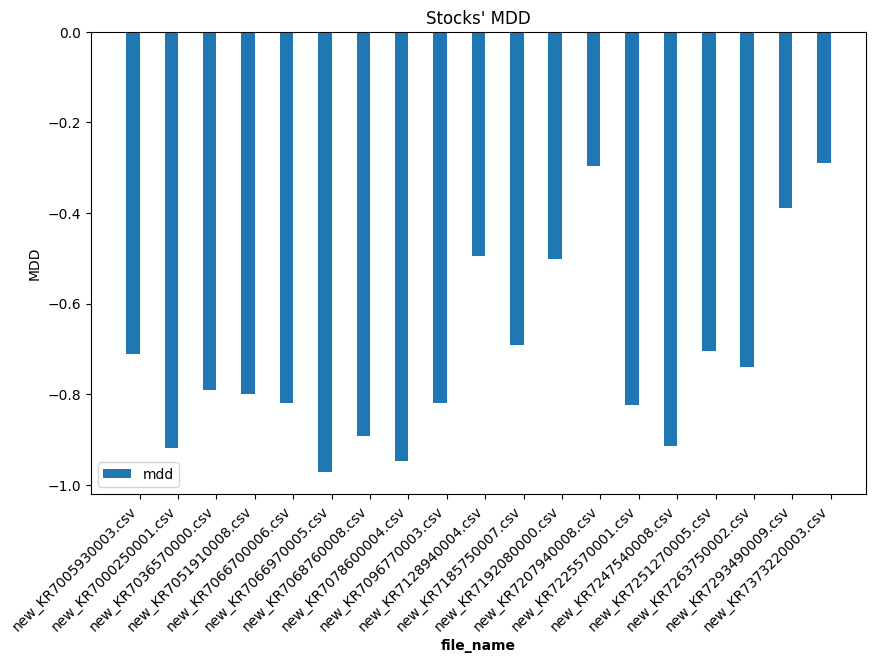

In [ ]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
barWidth = 0.35

# 각 파일에 대한 이익을 나란히 그리기
r1 = range(len(mdd_df['file_name']))
r2 = [x + barWidth for x in r1]

plt.bar(r1, mdd_df['mdd'], width=barWidth, label='mdd')

# x축에 파일 이름 표시하고 사선으로 회전
plt.xlabel('file_name', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(mdd_df['file_name']))], mdd_df['file_name'], rotation=45, ha="right")

# 그래프에 제목과 레이블 추가
plt.title("Stocks' MDD")
plt.ylabel('MDD')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()